In [19]:
%run key_imports.py
%run sabr.py
%run nn_archi.py
%run utils.py

X_df = pd.read_csv("datasets/sabr.csv")
X_df["K"] = -np.log(X_df["K"])  # negative strike instead
feat_names = ["K", "ttm", "V", "vol_of_vol", "beta", "rho"]
f_to_i = lambda x: feat_names.index(x)
Xs = X_df[feat_names].values
ys = X_df["digital_MC"]

print("BASELINE MSE: ", np.mean((ys - ys.mean()) ** 2))
print("BASELINE MAE: ", np.mean(np.abs(ys - ys.mean())))

all_res = []

BASELINE MSE:  0.23870827601789277
BASELINE MAE:  0.4837509002611036


Epoch 1/30
12800/12800 [==============================] - 25s 2ms/step - loss: 0.0044 - mean_absolute_error: 0.0153 - root_mean_squared_error: 0.0660 - val_loss: 3.7655e-04 - val_mean_absolute_error: 0.0056 - val_root_mean_squared_error: 0.0194
Epoch 2/30
12800/12800 [==============================] - 20s 2ms/step - loss: 5.7939e-04 - mean_absolute_error: 0.0063 - root_mean_squared_error: 0.0241 - val_loss: 3.5351e-04 - val_mean_absolute_error: 0.0054 - val_root_mean_squared_error: 0.0188
Epoch 3/30
12800/12800 [==============================] - 23s 2ms/step - loss: 4.3046e-04 - mean_absolute_error: 0.0058 - root_mean_squared_error: 0.0207 - val_loss: 3.1194e-04 - val_mean_absolute_error: 0.0053 - val_root_mean_squared_error: 0.0177
Epoch 4/30
12800/12800 [==============================] - 20s 2ms/step - loss: 3.7306e-04 - mean_absolute_error: 0.0056 - root_mean_squared_error: 0.0193 - val_loss: 2.8943e-04 - val_mean_absolute_error: 0.0052 - val_root_mean_squared_error: 0.0170
Epoch 5/

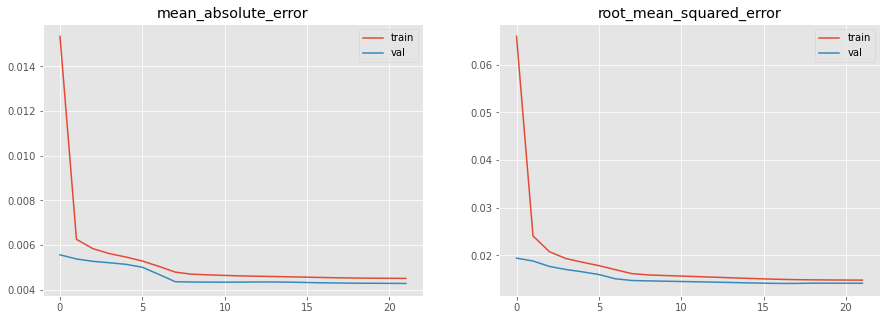

In [17]:
HIDDEN_UNITS = 100
LAYERS = 2
dropout_ratio = 0.0
HIDDEN_ACT = "softplus"
N_FEATS = Xs.shape[1]
OUTPUT_ACT = "sigmoid"
DROPOUT_RATIO = 0.0
LR = 1e-3
BATCH_SIZE = 32
EPOCHS = 30
BATCH_NORM = False

"""
Unconstrained NN
"""
loss_fn = tf.keras.losses.MeanSquaredError()
# loss_fn = tf.keras.losses.BinaryCrossentropy()

METRICS = [
    tf.keras.metrics.MeanAbsoluteError(),
    tf.keras.metrics.RootMeanSquaredError(),
]
VAL_SPLIT = 0.2
CALLBACKS = [EarlyStopping(patience=5)]


opt = Adam(learning_rate=LR)
ffn = make_model(
    N_FEATS, HIDDEN_UNITS, LAYERS, DROPOUT_RATIO, HIDDEN_ACT, OUTPUT_ACT, BATCH_NORM
)


ffn.compile(optimizer=opt, loss=loss_fn, metrics=METRICS)
start = time.time()
history = ffn.fit(
    Xs,
    ys,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VAL_SPLIT,
    shuffle=False,
    verbose=1,
    callbacks=CALLBACKS,
)
end = time.time()

metrics = ["mean_absolute_error", "root_mean_squared_error"]
fig, ax = plt.subplots(figsize=(15, 5), ncols=2)
for i, metric in enumerate(metrics):
    ax[i].plot(history.history[metric], label="train")
    ax[i].plot(history.history[f"val_{metric}"], label="val")
    ax[i].legend()
    ax[i].set_title(metric)

matplotlib.axes._subplots.Axes3DSubplot

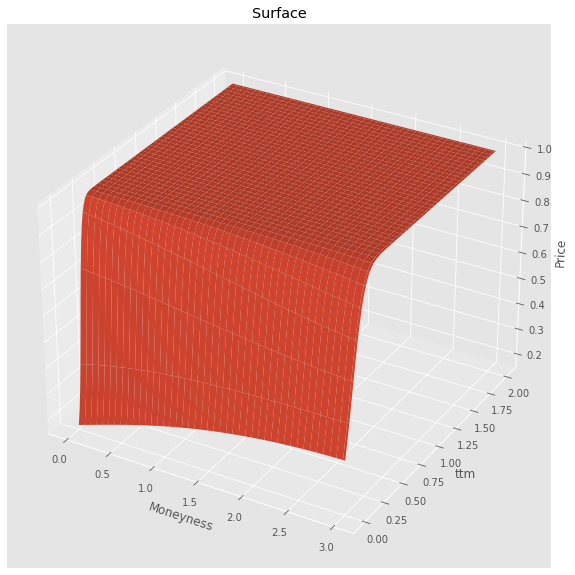

In [18]:
"""
Prediction Errors
"""
model = ffn
moneyness = Xs[:, f_to_i("K")]
ttm = Xs[:, f_to_i("ttm")]
true = X_df["digital_MC"]
intrinsic_val = None
preds = model.predict(Xs)
try:
    preds = preds.reshape(-1)
except:
    pass

"""
Compute all Gradients, Hessian
"""

X_tensor = tf.Variable(Xs)
with tf.GradientTape() as tape2:
    with tf.GradientTape() as tape:
        output = model(X_tensor)
        grads = tape.gradient(output, X_tensor)
    hessian1 = tape2.gradient(grads[:, f_to_i("K")], X_tensor)

grads = grads.numpy()
hessian_moneyness = hessian1.numpy()[:, [0]]

# all_res += [bs_eval_wrapper(X_df,
#                     true_val = X_df['call_true'].values,
#                     preds = preds,
#                     grads = grads,
#                     hessian_moneyness = hessian_moneyness,
#                     lower_bound = intrinsic_val,
#                     upper_bound = None,
#                     METHOD = "standard_ffn"
#                     )]

"""
Visualise call surface
"""
N_POINTS = 128
SK = np.linspace(0.0, 3, N_POINTS)
ts = np.linspace(0, 2.0, N_POINTS)
X = np.zeros((N_POINTS ** 2, N_FEATS))
X[:, :2] = np.array(list(product(SK, ts)))
X[:, f_to_i("V")] = 0.2
X[:, f_to_i("vol_of_vol")] = 0.1
X[:, f_to_i("rho")] = 0.3
X[:, f_to_i("beta")] = 1.0

temp = visualise_surface(SK, ts, model(X).numpy())
type(temp)

<AxesSubplot:>

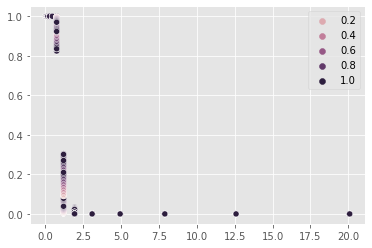

In [9]:
preds = model.predict(Xs).reshape(-1)
sns.scatterplot(x=Xs[:, f_to_i("K")], y=preds, hue=Xs[:, f_to_i("ttm")])

<AxesSubplot:>

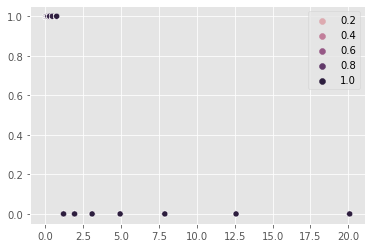

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression

X2 = PolynomialFeatures(degree=5).fit_transform(Xs)

logit_reg = LogisticRegression(fit_intercept=False).fit(X2, (X_df["digital_MC"] > 0.5))

preds = logit_reg.predict_proba(X2)[:, 1]
sns.scatterplot(x=Xs[:, f_to_i("K")], y=preds, hue=Xs[:, f_to_i("ttm")])

In [ ]:
pd.concat(all_res).T.style.background_gradient()